# Comparing RNN models on financial data


In [1]:
### Pour utiliser sur google colab

import os

from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v
#!google-drive-ocamlfuse drive

cwd = os.getcwd()

#### Changez le chemin ci-dessous vers votre repertoire dans votre googledrive
##############################################################################

monchemin = 'drive/My Drive/univ/master-2/deep-learning/6/'

dir_path  = os.path.join(cwd, monchemin)
dirs = os.listdir(dir_path)
os.chdir(dir_path)

###  

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Getting the data

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
# First, we get the data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [0]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

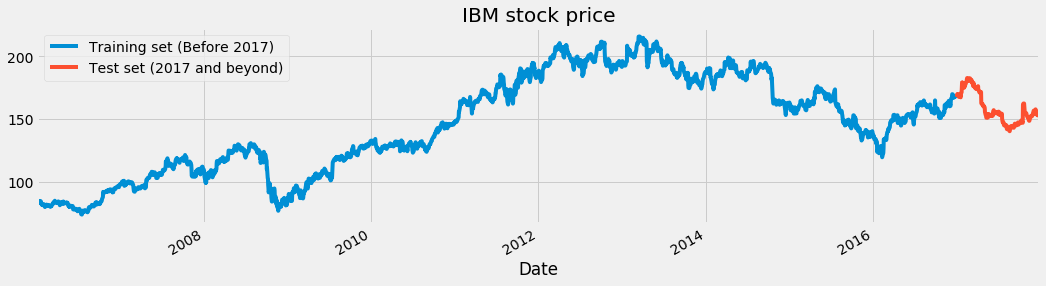

In [7]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [0]:
# Scaling the training set
from sklearn.preprocessing import StandardScaler
#sc = MinMaxScaler(feature_range=(0,1))
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

In [0]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
from sklearn.preprocessing import StandardScaler
X_test = []
y_test = []
#sc = MinMaxScaler(feature_range=(0,1))
sc=StandardScaler()
test_set_scaled = sc.fit_transform(test_set)
for i in range(60,251):
    X_test.append(test_set_scaled[i-60:i,0])
    y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


## Experimental comparison

1. Perform learning and plot the predictions of a few learned models   

2. Extensive comparison

Compare SimpleRNN, GRUU NNs, LSTM NNs in terms of performance (mse) vs number of parameters for a variery of models while tryoing to get the best performance for a given budget measured as the number of parameters.

Can you find a clear ranking of the three families of models ? 

3. Can these models be trained to perform prediction at a longer range ? For instance predicting the values of one full week ahead (the next 7 days) instead of predicting the value for the next only ?  
     
     

### SimpleRNN

In [12]:
from keras.layers import SimpleRNN, LSTM
from keras.optimizers import Adam
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(512, return_sequences=True,input_shape=(X_train[0].shape),activation='tanh'))
simple_rnn_model.add(Dropout(0.2))
simple_rnn_model.add(SimpleRNN(1,activation=None))

simple_rnn_model.summary()

simple_rnn_model.compile(loss="mean_squared_error",optimizer='adam', metrics=['accuracy'])
simple_rnn_model.fit(X_train,y_train,epochs=3)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 60, 512)           263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 512)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1)                 514       
Total params: 263,682
Trainable params: 263,682
Non-trainable params: 0
_________________________________________________________________




Epoch 1/3





2709/2709 [==============================] - 15s 6ms/step - loss: 1.1291 - acc: 0.0000e+00
Epoch 2/3
2709/2709 [==============================] - 15s 6ms/step - loss: 1.8589 - acc: 0.0000e+00
Epoch 3/3
2709/2709 [===========================

In [13]:
print(f'test loss, score {simple_rnn_model.evaluate(X_test,y_test, verbose=0)}')
print(f'train loss, score {simple_rnn_model.evaluate(X_train,y_train, verbose=0)}')

test loss, score [0.35409054394167755, 0.0]
train loss, score [0.519418833670734, 0.0]


### GRU

In [14]:
GRU_model = Sequential()
GRU_model.add(GRU(300, return_sequences=True,input_shape=(X_train[0].shape),activation='tanh'))
GRU_model.add(Dropout(0.2))
GRU_model.add(GRU(1,activation=None))

GRU_model.summary()

GRU_model.compile(loss="mean_squared_error",optimizer='adam', metrics=['accuracy'])
GRU_model.fit(X_train,y_train,epochs=3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 300)           271800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 300)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 906       
Total params: 272,706
Trainable params: 272,706
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
2709/2709 [==============================] - 20s 7ms/step - loss: 0.0471 - acc: 0.0000e+00
Epoch 2/3
2709/2709 [==============================] - 19s 7ms/step - loss: 0.0064 - acc: 0.0000e+00
Epoch 3/3
2709/2709 [==============================] - 19s 7ms/step - loss: 0.0060

In [15]:
print(f'test loss, score {GRU_model.evaluate(X_test,y_test, verbose=0)}')
print(f'train loss, score {GRU_model.evaluate(X_train,y_train, verbose=0)}')

test loss, score [0.0466653248441469, 0.0]
train loss, score [0.005309065428124819, 0.0]


In [0]:
# y_test_star = (simple_rnn_model.predict(X_test))
# print(y_test_star[:5,0],y_test[:5])
# y_train_star = (simple_rnn_model.predict(X_train))
# print(y_train_star[:5,0],y_train[:5])

### LSTM

In [17]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(256,return_sequences=True,input_shape=(X_train[0].shape),activation='tanh'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(1, return_sequences=False))
LSTM_model.add(Dropout(0.2))

LSTM_model.summary()

LSTM_model.compile(loss="mean_squared_error",optimizer='adam', metrics=['accuracy'])
LSTM_model.fit(X_train,y_train,epochs=3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 256)           264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 1032      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
Total params: 265,224
Trainable params: 265,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2709/2709 [==============================] - 20s 7ms/step - loss: 0.2741 - acc: 0.0000e+00
Epoch 2/3
2709/2709 [==============================] - 18s 7ms/step - loss: 0.2161 - acc: 0.0000e+00
Epoch 3/3
2709/2709 [=======================

In [18]:
print(f'test loss, score {LSTM_model.evaluate(X_test,y_test, verbose=0)}')
print(f'train loss, score {LSTM_model.evaluate(X_train,y_train, verbose=0)}')

test loss, score [0.10620667900480525, 0.0]
train loss, score [0.09299191731262378, 0.0]


Can these models be trained to perform prediction at a longer range ? For instance predicting the values of one full week ahead (the next 7 days) instead of predicting the value for the next only ?

In [18]:
X_test = []
y_test = []
#sc = MinMaxScaler(feature_range=(0,1))
sc=StandardScaler()
test_set_scaled = sc.fit_transform(test_set)
for i in range(7,251):
    X_test.append(test_set_scaled[i-7:i,0])
    y_test.append(test_set_scaled[i-7:i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

X_train = []
y_train = []

#sc = MinMaxScaler(feature_range=(0,1))
sc=StandardScaler()
train_set_scaled = sc.fit_transform(training_set)
for i in range(7,2769):
    X_train.append(train_set_scaled[i-7:i,0])
    y_train.append(train_set_scaled[i-7:i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
y_train = np.reshape(X_train, (y_train.shape[0],y_train.shape[1],1))

print(X_test.shape,y_test.shape)

(244, 7, 1) (244, 7, 1)


In [19]:
print(y_train.shape,X_train.shape)
print(y_week_train.shape,x_week_train.shape)
# (batch_size, timesteps, units)

GRU_model = Sequential()
GRU_model.add(GRU(300, return_sequences=True,input_shape=(X_train[0].shape),activation='tanh'))
GRU_model.add(Dropout(0.2))
GRU_model.add(GRU(1,return_sequences=True,activation=None))

GRU_model.summary()

GRU_model.compile(loss="mean_squared_error",optimizer='adam')
GRU_model.fit(X_train,y_train,epochs=3)

print(GRU_model.evaluate(X_test,y_test))
print(GRU_model.evaluate(X_train,y_train))

print(GRU_model.predict(X_test)[0][:,0])
print(y_test[0][:,0])

(2762, 7, 1) (2762, 7, 1)


NameError: ignored